**Ensemble model for fast forward solver.**

Author: Rahul K K

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/GPR_Forward_Solver/ml_model_generating_ascan

Mounted at /content/drive
/content/drive/My Drive/GPR_Forward_Solver/ml_model_generating_ascan


In [2]:


import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [3]:
from sklearn.preprocessing import StandardScaler

def normalize_data(X_train, X_val, X_test,Y_train,Y_val,Y_test):
    """
    Normalize the training, validation, and test data using StandardScaler.

    Args:
        X_train (numpy.ndarray): Training data.
        X_val (numpy.ndarray): Validation data.
        X_test (numpy.ndarray): Test data.

    Returns:
        tuple: Normalized training, validation, and test data.
    """
    scaler = StandardScaler()

    X_train_norm = scaler.fit_transform(X_train)
    X_val_norm = scaler.transform(X_val)
    X_test_norm = scaler.transform(X_test)

    Y_train_norm = scaler.fit_transform(Y_train)
    Y_val_norm = scaler.transform(Y_val)
    Y_test_norm = scaler.transform(Y_test)
    return X_train_norm, X_val_norm, X_test_norm, Y_train_norm, Y_val_norm, Y_test_norm

In [4]:
# Load the data
X = np.load('combined_label_matrix.npy')  # Input data (1636 x 3)
X = X.transpose()
y = np.load('pca_transformed_ascan.npy')  # Output data (1636 x 40)

# Split the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Normalize
X_train, X_val, X_test, y_train, y_val, y_test  = normalize_data(X_train, X_val, X_test, y_train, y_val, y_test )
print(min(X_train[0]))
print(max(X_train[0]))
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

1.1476550877775773
1.673357517780234
Train set shape: (981, 3) (981, 40)
Validation set shape: (327, 3) (327, 40)
Test set shape: (328, 3) (328, 40)


In [5]:


# Define the model
model = Sequential()

# Input layer with 3 nodes (for input parameters R, D, MC)
model.add(Dense(300, input_dim=3, activation='relu'))

# Hidden layers (5 layers with 300 nodes each, using ReLU activation)
for _ in range(4):
    model.add(Dense(300, activation='relu'))

# Output layer with 40 nodes (PCA components of each A-scan)
model.add(Dense(40, activation='linear'))

# Compile the model with Adam optimizer, MSE loss function, and learning rate decay
initial_learning_rate = 0.001
decay_rate = 1e-7

optimizer = Adam(learning_rate=initial_learning_rate, decay=decay_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Summary of the model
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 300)                 │           1,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 300)                 │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 300)                 │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 300)                 │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 300)                 │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 40)                  │          12,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 374,440 (1.43 MB)

 Trainable params: 374,440 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:

# Ensemble averaging implementation
def train_ensemble_models(X_train, y_train, X_val, y_val, num_models=40, epochs=100, batch_size=32):
    models = []
    for i in range(num_models):
        print(f"Training model {i+1}/{num_models}")
        model = Sequential()
        model.add(Dense(300, input_dim=3, activation='relu'))
        for _ in range(4):
            model.add(Dense(300, activation='relu'))
        model.add(Dense(40, activation='linear'))
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0)
        models.append(model)
    return models

def ensemble_predict(models, X_test):
    predictions = [model.predict(X_test) for model in models]
    return tf.reduce_mean(predictions, axis=0)



In [7]:
# # Example usage
# # X_train, y_train, X_val, y_val, X_test are assumed to be preprocessed and available
# models = train_ensemble_models(X_train, y_train, X_val, y_val)
# y_pred = ensemble_predict(models, X_test)

In [8]:
# Ensemble averaging implementation
def train_ensemble_models(X_train, y_train, X_val, y_val, num_models=40, epochs=100, batch_size=32):
    models = []
    initial_learning_rate = 0.001
    decay_rate = 1e-7
    for i in range(num_models):
        print(f"Training model {i+1}/{num_models}")
        model = Sequential()
        model.add(Dense(300, input_dim=3, activation='relu'))
        for _ in range(4):
            model.add(Dense(300, activation='relu'))
        model.add(Dense(40, activation='linear'))
        # Create a new optimizer instance for each model
        optimizer = Adam(learning_rate=initial_learning_rate, decay=decay_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0)
        models.append(model)
    return models

def ensemble_predict(models, X_test):
    predictions = [model.predict(X_test) for model in models]
    return tf.reduce_mean(predictions, axis=0)

In [9]:
# Example usage
# X_train, y_train, X_val, y_val, X_test are assumed to be preprocessed and available
models = train_ensemble_models(X_train, y_train, X_val, y_val, num_models=40, epochs=100, batch_size=32)
y_pred = ensemble_predict(models, X_test)



Training model 1/40
Training model 2/40
Training model 3/40
Training model 4/40
Training model 5/40
Training model 6/40
Training model 7/40
Training model 8/40
Training model 9/40
Training model 10/40
Training model 11/40
Training model 12/40
Training model 13/40
Training model 14/40
Training model 15/40
Training model 16/40
Training model 17/40
Training model 18/40
Training model 19/40
Training model 20/40
Training model 21/40
Training model 22/40
Training model 23/40
Training model 24/40
Training model 25/40
Training model 26/40
Training model 27/40
Training model 28/40
Training model 29/40
Training model 30/40
Training model 31/40
Training model 32/40
Training model 33/40
Training model 34/40
Training model 35/40
Training model 36/40
Training model 37/40
Training model 38/40
Training model 39/40
Training model 40/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━

In [10]:
import os
from tensorflow.keras.models import load_model

def save_ensemble_models(models, output_file):
    """
    Save an ensemble of Keras models to an H5 file.

    Args:
        models (list): List of trained Keras models.
        output_file (str): Path to the output H5 file.
    """
    # if not os.path.exists(os.path.dirname(output_file)):
    #     os.makedirs(os.path.dirname(output_file))

    for i, model in enumerate(models):
        model_file = f"model_{i}.h5" #os.path.join(output_file, f"model_{i}.h5")
        model.save(model_file)
        print(f"Saved model {i} to {model_file}")

# Example usage
save_ensemble_models(models, "ensemble_models.h5")

Saved model 0 to model_0.h5


Saved model 1 to model_1.h5


Saved model 2 to model_2.h5


Saved model 3 to model_3.h5


Saved model 4 to model_4.h5


Saved model 5 to model_5.h5


Saved model 6 to model_6.h5


Saved model 7 to model_7.h5


Saved model 8 to model_8.h5


Saved model 9 to model_9.h5


Saved model 10 to model_10.h5


Saved model 11 to model_11.h5


Saved model 12 to model_12.h5


Saved model 13 to model_13.h5


Saved model 14 to model_14.h5


Saved model 15 to model_15.h5


Saved model 16 to model_16.h5


Saved model 17 to model_17.h5


Saved model 18 to model_18.h5


Saved model 19 to model_19.h5


Saved model 20 to model_20.h5


Saved model 21 to model_21.h5


Saved model 22 to model_22.h5


Saved model 23 to model_23.h5


Saved model 24 to model_24.h5


Saved model 25 to model_25.h5


Saved model 26 to model_26.h5


Saved model 27 to model_27.h5


Saved model 28 to model_28.h5


Saved model 29 to model_29.h5


Saved model 30 to model_30.h5


Saved model 31 to model_31.h5


Saved model 32 to model_32.h5


Saved model 33 to model_33.h5


Saved model 34 to model_34.h5


Saved model 35 to model_35.h5


Saved model 36 to model_36.h5


Saved model 37 to model_37.h5


Saved model 38 to model_38.h5
Saved model 39 to model_39.h5


In [11]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Function to evaluate model performance
def evaluate_performance(y_true, y_pred):
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # Calculate R² score
    r2 = r2_score(y_true, y_pred)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R² Score: {r2}")

    return mse, rmse, r2

# Example usage after getting predictions from ensemble
# Assuming y_test is available as true values
# y_pred = ensemble_predict(models, X_test)
mse, rmse, r2 = evaluate_performance(y_test, y_pred)

Mean Squared Error (MSE): 0.4100993275642395
Root Mean Squared Error (RMSE): 0.6403899788856506
R² Score: 0.5956405996964514


**Comparing the reconstructed from predicted and original.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Mean Squared Error (MSE): 0.10321296751499176


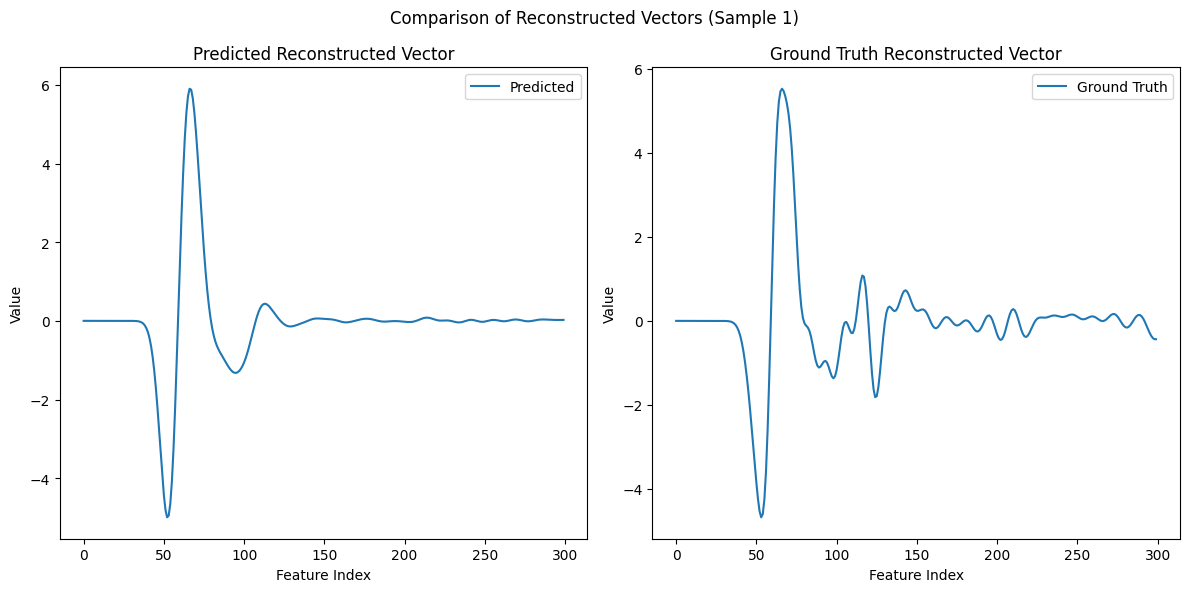

In [14]:

from joblib import load
import matplotlib.pyplot as plt
#Load the PCA model
pca = load('pca_model.joblib')


# Get a sample index from the test set
sample_index = 1  # Change this to the index of the sample you want to visualize

# Get the predicted PCA components for the sample
sample_input = X_test[sample_index].reshape(1, -1)
sample_predicted_pca = model.predict(sample_input)

# Get the ground truth PCA components for the sample
sample_true_pca = y_test[sample_index]

# Reconstruct the original 300-dimensional vectors
sample_predicted_vector = pca.inverse_transform(sample_predicted_pca)
sample_true_vector = pca.inverse_transform([sample_true_pca])
#Estimate the mean square error between the two vectors
mse = mean_squared_error(sample_true_vector, sample_predicted_vector)
print(f"Mean Squared Error (MSE): {mse}")
# Visualize the comparison
plt.figure(figsize=(12, 6))

# Plot the predicted reconstructed vector
plt.subplot(1, 2, 1)
plt.plot(sample_predicted_vector[0], label='Predicted')
plt.title('Predicted Reconstructed Vector')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()

# Plot the ground truth reconstructed vector
plt.subplot(1, 2, 2)
plt.plot(sample_true_vector[0], label='Ground Truth')
plt.title('Ground Truth Reconstructed Vector')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()

plt.suptitle(f'Comparison of Reconstructed Vectors (Sample {sample_index})')
plt.tight_layout()
plt.show()
# # Visualize the comparison
# plt.figure(figsize=(12, 6))
# plt.plot(range(len(sample_reconstructed_pred)), sample_reconstructed_pred, label='Predicted')
# plt.plot(range(len(sample_true_300)), sample_true_300, label='Ground Truth')
# plt.title(f'Comparison of Reconstructed Vectors (Sample {sample_index})')
# plt.xlabel('Feature Index')
# plt.ylabel('Value')
# plt.legend()
# plt.tight_layout()
# plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


<ipython-input-24-0917058808df>:42: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


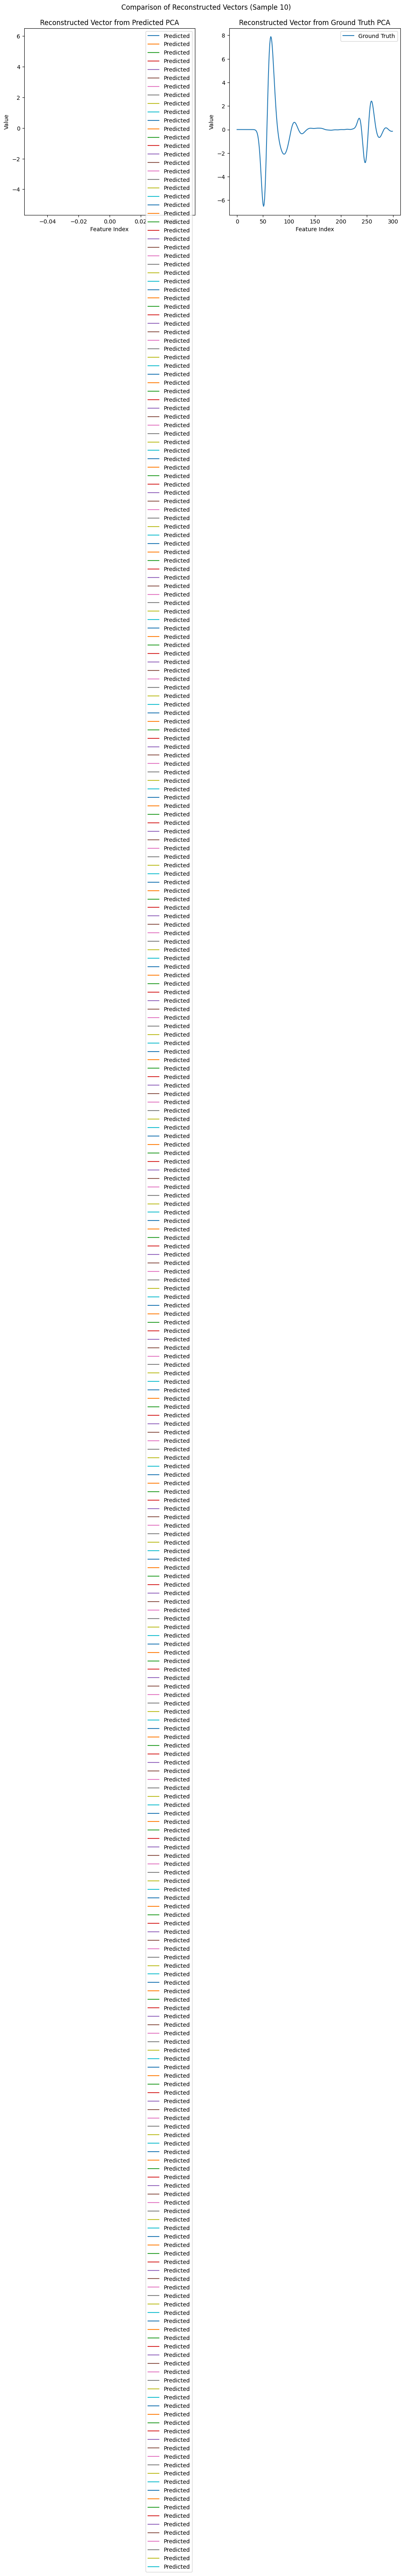

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import load

# Load the PCA model
pca = load('pca_model.joblib')



# Select a sample from the test set
sample_idx = 10  # Choose the index of the sample you want to visualize

# Get the predicted PCA components for the sample
# Get the predicted PCA components for the sample
sample_input = X_test[sample_index].reshape(1, -1)
sample_predicted_pca = model.predict(sample_input)

# Reconstruct the original 300-dimensional vector from the predicted PCA components
sample_reconstructed_pred = pca.inverse_transform([sample_predicted_pca])[0]

# Get the ground truth 300-dimensional vector from the test set
sample_true_300 = pca.inverse_transform([y_test[sample_idx]])[0]

# Plot the comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(sample_reconstructed_pred)), sample_reconstructed_pred, label='Predicted')
plt.title('Reconstructed Vector from Predicted PCA')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(sample_true_300)), sample_true_300, label='Ground Truth')
plt.title('Reconstructed Vector from Ground Truth PCA')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()

plt.suptitle(f'Comparison of Reconstructed Vectors (Sample {sample_idx})')
plt.tight_layout()
plt.show()